In [2]:
!pip install pandas

  Using cached pandas-2.2.2-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached pandas-2.2.2-cp312-cp312-win_amd64.whl (11.5 MB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)


In [4]:
!pip install numpy

  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)


In [7]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [16]:
import pandas as pd
import numpy as np
# import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor

<Axes: >

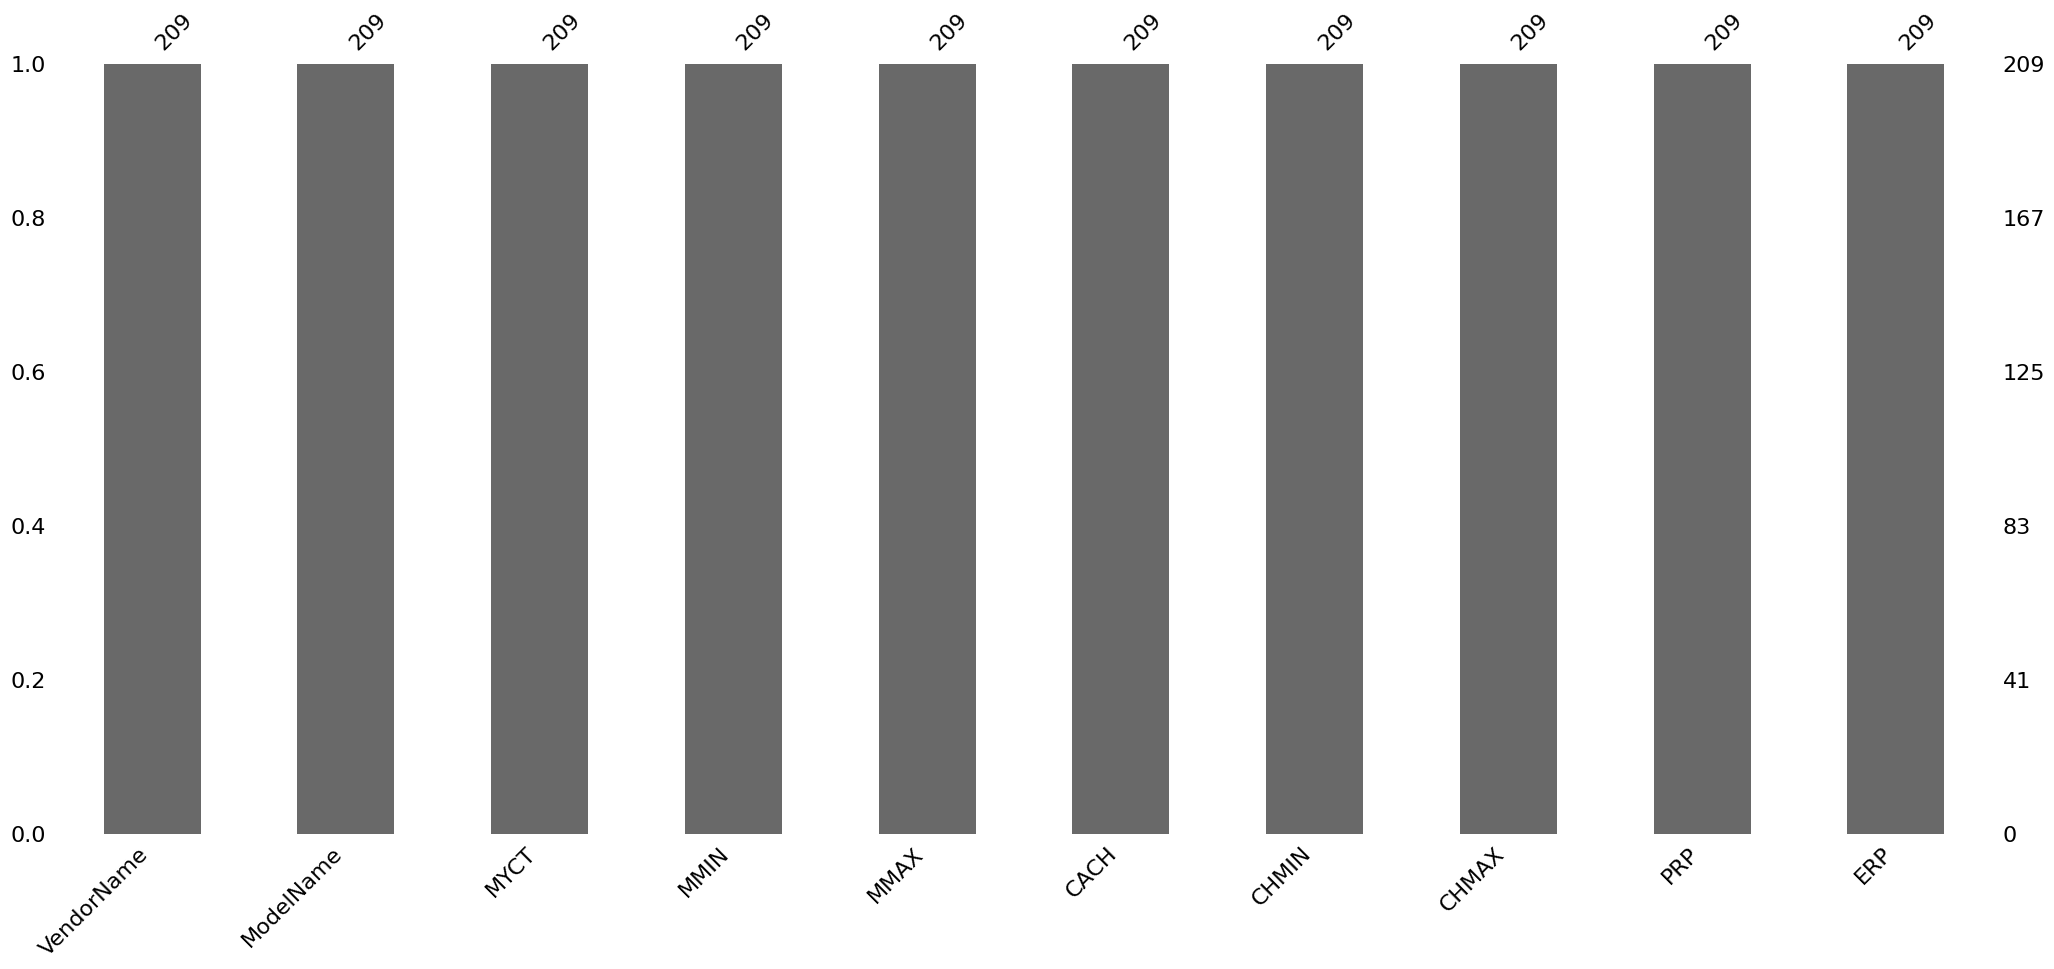

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
## csv로 저장되어 있는 값을 pandas의 DataFrame 값으로 변환 하기
machine = pd.read_csv("machine.data_update.csv")
## 컬럼이 무엇이 있는지 확인
machine.columns
import missingno as msn
# 결측값의 개수를 막대 그래프로 시각화 한다.
msn.bar(machine)

In [18]:
# 정확성을 위해서 결측치의 값을 제거해 준다
# 결측치가 하나도 없는 것을 알 수 있다.
machine.dropna(inplace = True)
#결측치가 없는 것을 확인했기 때문에 PRP와의 상관 관계를 계산해서 변수를 선택해줘야한다.
# pandas 라이브러리에 포함된 DataFrame의 메서드인 corr() 메서드를 사용해야 한다.
# 또한 상관도를 구할 때 모든 변수들의 값은 수치화 되어야 한다.
# 모든 변수를 수치화 한다.
dums = pd.get_dummies(machine, dtype=float)
# PRP와의 상관계수 계산
prp_resulte = dums.corr()['PRP']
# 상관계수 값을 절대값으로 변환
# 변환의 이유는 간단하다. corr() 메서드가 -1~1의 값을 가져오기 때문이다.
prp_resulte= np.abs(prp_resulte)

In [19]:
# 상관계수를 내림차순으로 정렬
prp_resulte.sort_values(ascending=False)
# 내림차순으로 선택 후 상관 관계가 높은 features 선택
num_features = prp_resulte.sort_values(ascending=False).index[1:6].tolist()
X_train = dums[num_features]
X_test = dums[num_features]
y_train = dums['PRP']
y_test = dums['PRP']

In [20]:
# 앙상블 기법으로 모델 생성 및 학습  : LinearRegression, SGDRegressor, Ridge, GradientBoostingRegressor
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_features)])
# 개별 모델 정의
models = [
    ('lr', LinearRegression()),
    ('sgd', SGDRegressor()),
    ('ridge', Ridge(random_state=42)),
    ('gbr', GradientBoostingRegressor(random_state=42))
]
# 앙상블 모델 정의
ensemble = VotingRegressor(estimators=models)

# 모델 파이프라인 생성
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('ensemble', ensemble)])

# 하이퍼파라미터 튜닝
params_grid = {
    "ensemble__sgd__alpha": [0.0001, 0.1, 1.0],
    "ensemble__sgd__max_iter": [1000, 2000, 3000],
    "ensemble__ridge__alpha": [10, 20],
    "ensemble__gbr__n_estimators": [100, 200],
    "ensemble__gbr__learning_rate": [0.01, 0.1]
}
grid_search = GridSearchCV(model_pipeline, params_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['ERP',
                                                                          'MMAX',
                                                                          'MMIN',
                                                                          'CACH',
                                                                          'CHMIN'])])),
                                       ('ensemble',
                                        VotingRegressor(estimators=[('lr',
                                                                     LinearRegression()),
                                                                    ('sgd',
                                                                     SGDRegressor()),
                                                                    ('ridge',
                                                                     Ridge(random_state=42)),
                                                                    ('gbr',
                                                                     GradientBoostingRegressor(random_state=42))]))]),
             param_grid={'ensemble__gbr__learning_rate': [0.01, 0.1],
                         'ensemble__gbr__n_estimators': [100, 200],
                         'ensemble__ridge__alpha': [10, 20],
                         'ensemble__sgd__alpha': [0.0001, 0.1, 1.0],
                         'ensemble__sgd__max_iter': [1000, 2000, 3000]},
             return_train_score=True, scoring='neg_mean_squared_error')

Best parameters: {'ensemble__gbr__learning_rate': 0.01, 'ensemble__gbr__n_estimators': 200, 'ensemble__ridge__alpha': 20, 'ensemble__sgd__alpha': 0.0001, 'ensemble__sgd__max_iter': 1000}
Mean Squared Error: 1339.6756186300338
Mean Absolute Error: 22.60945329931911
R^2 Score: 0.9479591331993933


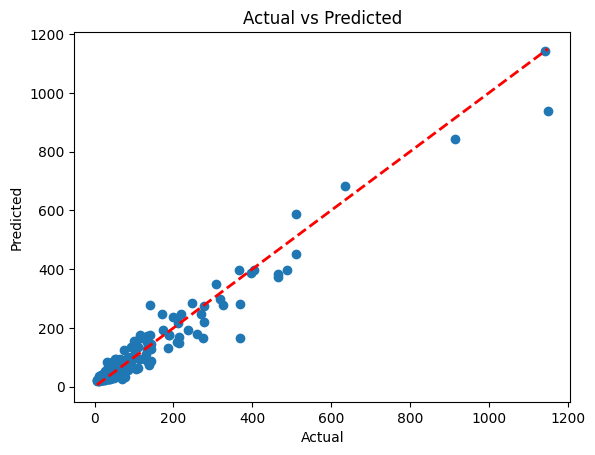

In [21]:
# 최적 파라미터를 이용하여 최적 모델로 예측하기
# 1) 최적 파라미터 출력
print(f'Best parameters: {grid_search.best_params_}')

# 최적 모델로 예측
best_model = grid_search.best_estimator_

# 2) 최적 모델 출력
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

# 최적 모델 성능 평가 및 시각화
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [15]:
## 성능 지표를 저장할 데이터 프레임을 만들어 준다
performance_metrics_formatted = pd.DataFrame(columns=['Model', 'Data', 'MSE', 'MAE', 'R^2'])
# 모델을 다시 선언 헤주는 이유는 간단하다. 위에는 리스트 형식으로 사용되었다.
# 우리는 딕셔너리 형태로 선언을 해주어야 한다.
models = {
    'Linear Regression': LinearRegression(),
    'SGD Regressor': SGDRegressor(),
    'Ridge': Ridge(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42)
}
for model_name, model in models.items():
    ## 전처리 및 파이프 라인을 만들어 준다.
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # 교차 검증을 통해서 mse, mae, r2의 점수를 계산해 준다. 
    cv_mse = -cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    cv_mae = -cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()
    cv_r2 = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='r2').mean()
    
    # 학습된 데이터를 사용해서 모델을 학습시킨다. 
    model_pipeline.fit(X_train, y_train)
    # 학습 데이터와 테스트 데이터의 대한 예측 값 
    y_pred_train = model_pipeline.predict(X_train)
    y_pred_test = model_pipeline.predict(X_test)
    
    # 학습 데이터에 대한 점수를 생성해준다.
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_r2 = r2_score(y_train, y_pred_train)
    
    # 테스트 데이터에 대한 점수를 생성해 준다. 
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)
    
    # 결과 값을 DataFrame에 추가 
    temp_df = pd.DataFrame({
        'Model': [model_name, model_name, model_name],
        'Data': ['Train', 'Test', 'Cross Validation'],
        'MSE': [train_mse, test_mse, cv_mse],
        'MAE': [train_mae, test_mae, cv_mae],
        'R^2': [train_r2, test_r2, cv_r2]
    })
    performance_metrics_formatted = pd.concat([performance_metrics_formatted, temp_df], ignore_index=True)
performance_metrics_formatted

C:\Users\navoodi\AppData\Local\Temp\ipykernel_7748\2137013552.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance_metrics_formatted = pd.concat([performance_metrics_formatted, temp_df], ignore_index=True)


,Model,Data,MSE,MAE,R^2
0,Linear Regression,Train,1633.017244,24.275005,0.936564
1,Linear Regression,Test,1633.017244,24.275005,0.936564
2,Linear Regression,Cross Validation,3451.470007,30.314186,0.836306
3,SGD Regressor,Train,1683.041800,24.331348,0.934621
4,SGD Regressor,Test,1683.041800,24.331348,0.934621
5,SGD Regressor,Cross Validation,3738.533706,30.735184,0.837334
6,Ridge,Train,1636.958416,24.225550,0.936411
7,Ridge,Test,1636.958416,24.225550,0.936411
8,Ridge,Cross Validation,3416.632524,30.144578,0.840080
9,Gradient Boosting Regressor,Train,266.851186,11.039865,0.989634


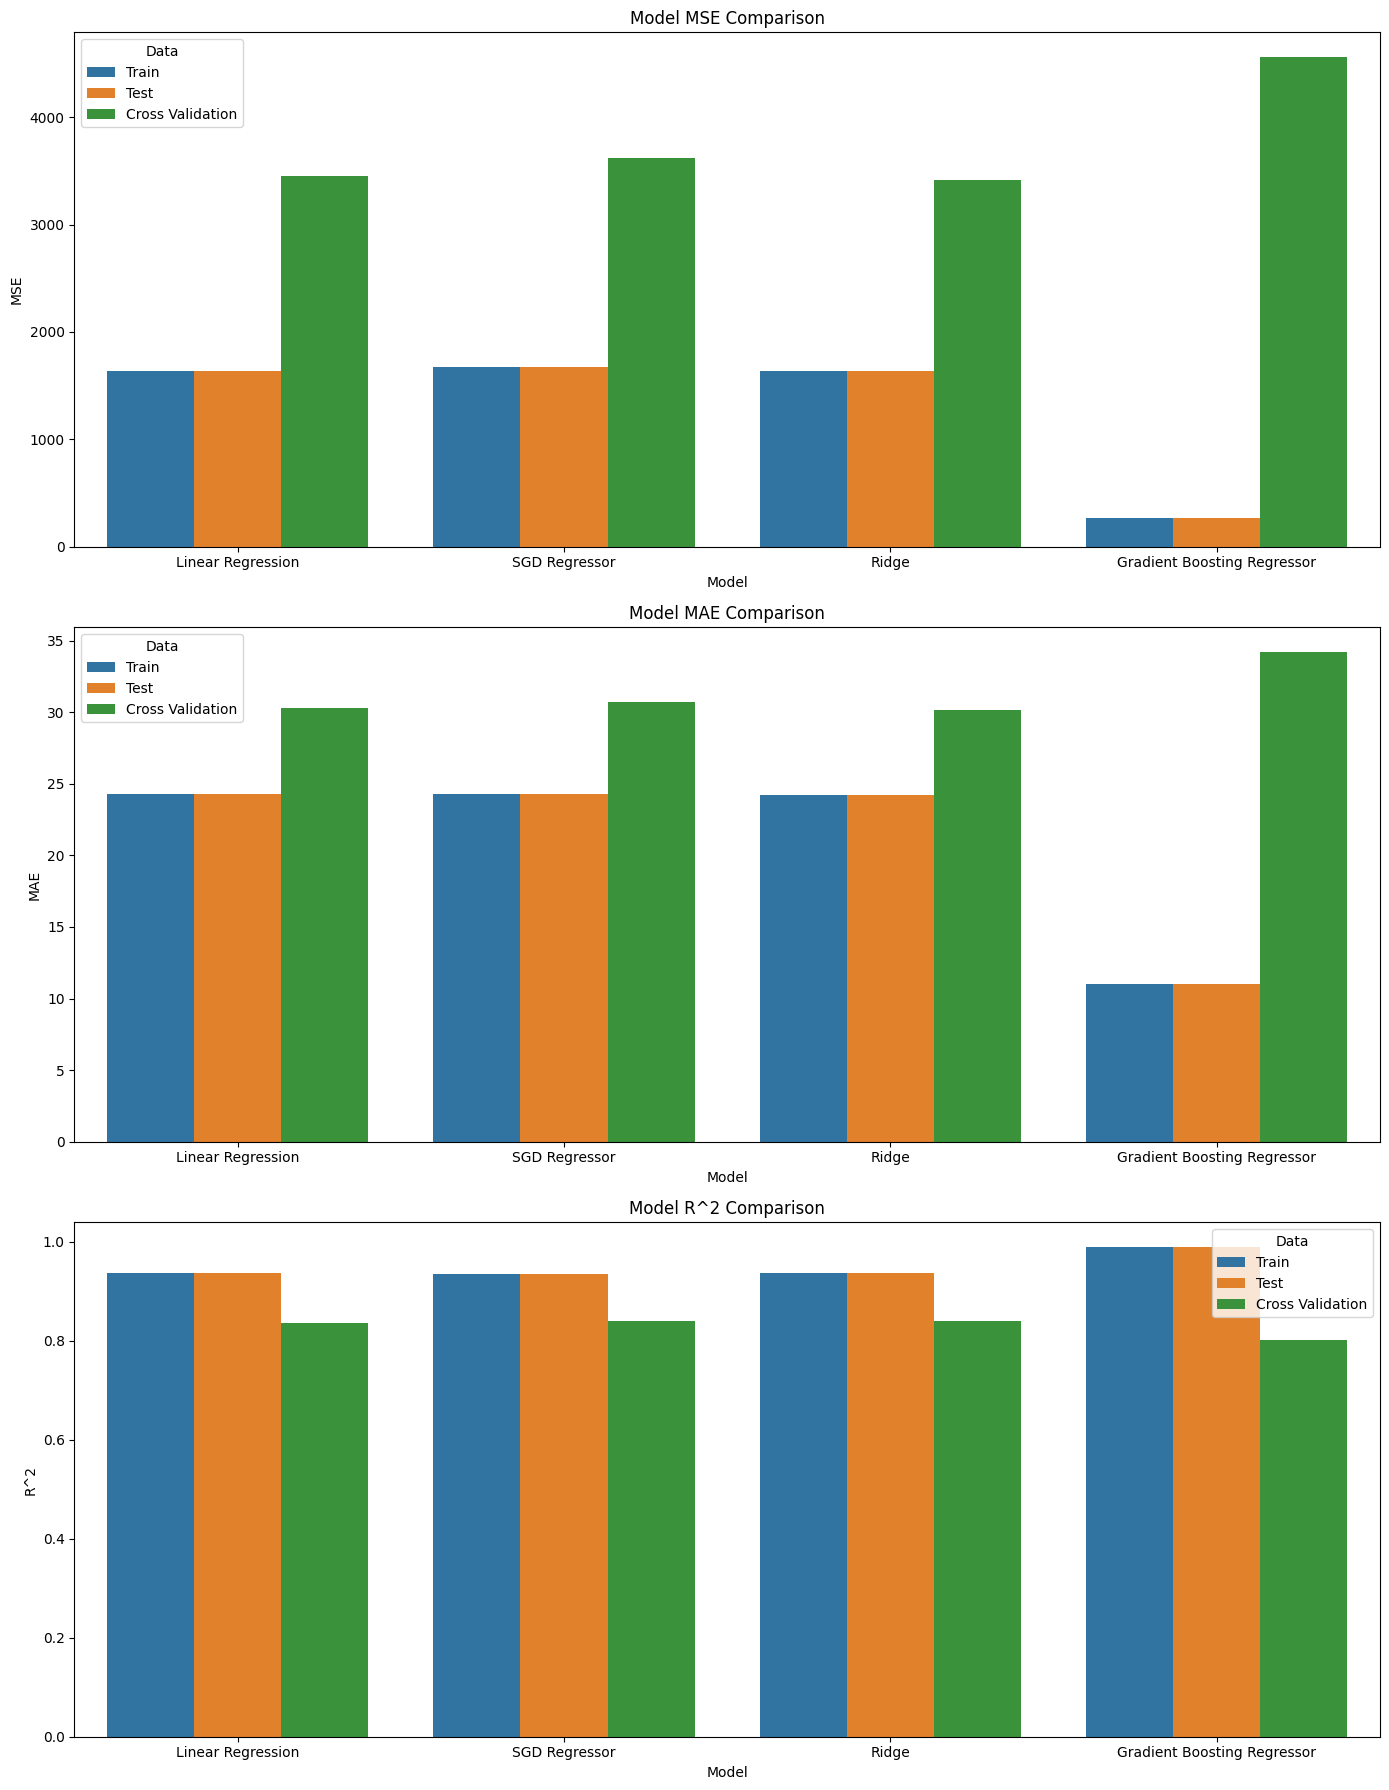

,Model,Data,MSE,MAE,R^2
0,Linear Regression,Train,1633.017244,24.275005,0.936564
1,Linear Regression,Test,1633.017244,24.275005,0.936564
2,Linear Regression,Cross Validation,3451.470007,30.314186,0.836306
3,SGD Regressor,Train,1670.646313,24.282383,0.935102
4,SGD Regressor,Test,1670.646313,24.282383,0.935102
5,SGD Regressor,Cross Validation,3615.004818,30.688030,0.838977
6,Ridge,Train,1636.958416,24.225550,0.936411
7,Ridge,Test,1636.958416,24.225550,0.936411
8,Ridge,Cross Validation,3416.632524,30.144578,0.840080
9,Gradient Boosting Regressor,Train,266.851186,11.039865,0.989634


In [13]:
# 화면을 3행 1열로 분할 시켜준다
# mse, mae, r^2 3개의 각각의 성능을 봐야 하기 때문이다.
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

sns.barplot(ax=axes[0], x='Model', y='MSE', hue='Data', data=performance_metrics_formatted)
axes[0].set_title('Model MSE Comparison')
axes[0].set_ylabel('MSE')

sns.barplot(ax=axes[1], x='Model', y='MAE', hue='Data', data=performance_metrics_formatted)
axes[1].set_title('Model MAE Comparison')
axes[1].set_ylabel('MAE')

sns.barplot(ax=axes[2], x='Model', y='R^2', hue='Data', data=performance_metrics_formatted)
axes[2].set_title('Model R^2 Comparison')
axes[2].set_ylabel('R^2')

plt.tight_layout()
plt.show()

